<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/12-rnn-alternatives/02_positional_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Positional embeddings

Embeddings are fast and potentially
very accurate but often overfit the data since they lack this sequential information. This
is hard to fix because the sequential information comes from our model design (i.e.,
using an RNN or CNN layer).

If the
embeddings themselves contain information about their relative order, can we improve
the results of our algorithms? 

That’s the idea behind a recent technique called a positional
encoding.

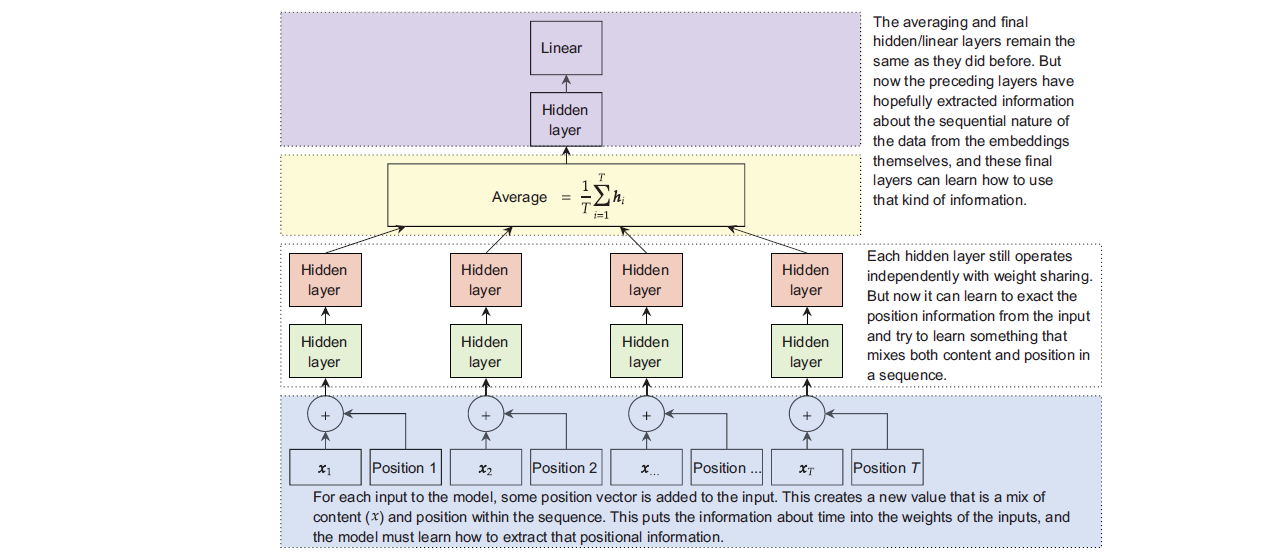

The big question is, how do we create this mythical encoding? It is a slightly mathy
approach, but not too complicated.

##Setup

In [ ]:
!pip install portalocker

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab

from torchtext.datasets import AG_NEWS

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import math
import time
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

from idlmam import set_seed
from idlmam import LastTimeStep, train_network, Flatten, weight_reset, View, LambdaLayer
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore #For attention mechanism use

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

In [5]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
import warnings
warnings.filterwarnings("ignore")

##AG News dataset

In [8]:
# let’s quickly load AG_NEWS dataset
train_iter, test_iter = AG_NEWS(root="./data", split=("train", "test"))

train_dataset = list(train_iter)
test_dataset = list(test_iter)

In [9]:
print(train_dataset[0])

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


In [10]:
# tokenizers break strings like "this is a string" into lists of tokens like ['this', 'is', 'a', 'string']
tokenizer = get_tokenizer("basic_english") # we will be fine with the default english style tokenizer

# we need to create a vocabulary of all the words in the training set
counter = Counter()
for (label, line) in train_dataset:
  # count the number of unique tokens we see and how often we see them (e.g., we will see "the" a lot, but "sasquatch" maybe once or not at all.)
  counter.update(tokenizer(line))
# create a vocab object, removing any word that didn't occur at least 10 times, 
# and add special vocab items for unkown, begining of sentance, end of sentance, and "padding"
vocab = vocab(counter, min_freq=10, specials=("<unk>", "<BOS>", "<EOS>", "<PAD>"))
vocab.set_default_index(vocab["<unk>"])

In [11]:
len(vocab)

20647

In [12]:
def text_transform(x):
  # vocab acts like a dictionary, handls unkown tokens.
  # We can make it pre- and post-pend with the start and end markers, respectively.
  return [vocab["<BOS>"]] + [vocab[token] for token in tokenizer(x)] + [vocab["<EOS>"]]

def label_transform(y):
  # labes are originally [1, 2, 3, 4] but we need them as [0, 1, 2, 3] 
  return y - 1

In [13]:
train_dataset[0][1]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [14]:
# let's transform the first data point's text into a list of tokens
print(text_transform(train_dataset[0][1]))

[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 14, 16, 0, 17, 4, 18, 19, 20, 0, 21, 0, 17, 22, 23, 24, 25, 6, 2]


In [15]:
# To make training faster, let’s limit ourselves to sentences that contain six or fewer words.
VOCAB_SIZE  = len(vocab)
NUM_CLASS = len(np.unique([z[0] for z in train_dataset]))
print(f"Vocab: {VOCAB_SIZE}")
print(f"Num Classes: {NUM_CLASS}")

padding_idx = vocab["<PAD>"]
embed_dim = 128
B = 64
epochs = 15

Vocab: 20647
Num Classes: 4


In [16]:
def pad_batch(batch):
  """
  Pad items in the batch to the length of the longest item in the batch. 
  Also, re-order so that the values are returned (input, label)
  """
  # transform every label in the batch
  labels = [label_transform(z[0]) for z in batch]
  # tokenizes every text and puts them into a tensor
  texts = [torch.tensor(text_transform(z[1]), dtype=torch.int64) for z in batch]

  # what is the longest sequence in this batch?
  max_len = max([text.size(0) for text in texts])
  # pad each text tensor by whatever amount gets it to the max_len
  texts = [F.pad(text, (0, max_len - text.size(0)), value=padding_idx) for text in texts]
  # make x and y a single tensor
  x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)
  return  x, y

In [17]:
# Now we can build our DataLoaders
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch)

In [18]:
iterator = iter(train_loader)

batch1 = next(iterator)

In [19]:
batch1

(tensor([[    1,  7034,  9930,  ...,     3,     3,     3],
         [    1,   721,  1952,  ...,     3,     3,     3],
         [    1,  1814,  1104,  ...,     3,     3,     3],
         ...,
         [    1, 20355,  3099,  ...,     3,     3,     3],
         [    1,    11,   386,  ...,     3,     3,     3],
         [    1,     0,    17,  ...,     3,     3,     3]]),
 tensor([1, 3, 3, 3, 1, 2, 0, 2, 1, 3, 3, 2, 2, 2, 2, 2, 0, 3, 1, 1, 3, 2, 3, 3,
         1, 1, 0, 2, 3, 3, 2, 3, 3, 2, 1, 0, 1, 3, 3, 1, 3, 1, 2, 1, 1, 3, 1, 2,
         3, 0, 1, 3, 1, 3, 1, 3, 0, 2, 3, 0, 1, 1, 3, 0]))

##Baseline model

In [20]:
gru = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx),  # (B, T) -> (B, T, D)
  nn.GRU(embed_dim, embed_dim, num_layers=3, batch_first=True, bidirectional=True), # (B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), # We need to take the RNN output and reduce it to one item, (B, 2*D)
  nn.Linear(embed_dim * 2, NUM_CLASS)    # (B, D) -> (B, classes)
)

loss_func = nn.CrossEntropyLoss()

In [ ]:
gru_results = train_network(gru, 
                            loss_func, 
                            train_loader, 
                            val_loader=test_loader, 
                            score_funcs={'Accuracy': accuracy_score}, 
                            device=device, epochs=epochs)

<Axes: xlabel='epoch', ylabel='val Accuracy'>

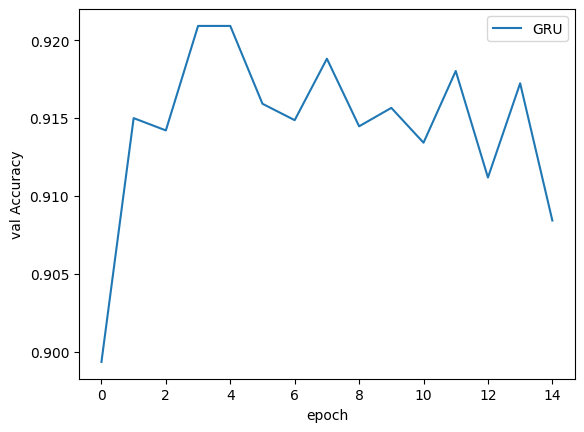

In [22]:
sns.lineplot(x="epoch", y="val Accuracy", data=gru_results, label="GRU")

##Average Embedding

In [23]:
simple_emb_average = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx),  # (B, T) -> (B, T, D)

  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),
  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),
  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),

  nn.AdaptiveAvgPool2d((1, embed_dim)),  # (B, T, D) -> (B, 1, D)
  nn.Flatten(),                          # (B, 1, D) -> (B, D)

  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),

  nn.BatchNorm1d(embed_dim),
  nn.Linear(embed_dim, NUM_CLASS)
)

In [ ]:
simple_emb_average_results = train_network(simple_emb_average, 
                            loss_func, 
                            train_loader, 
                            val_loader=test_loader, 
                            score_funcs={'Accuracy': accuracy_score}, 
                            device=device, epochs=epochs)

<Axes: xlabel='epoch', ylabel='val Accuracy'>

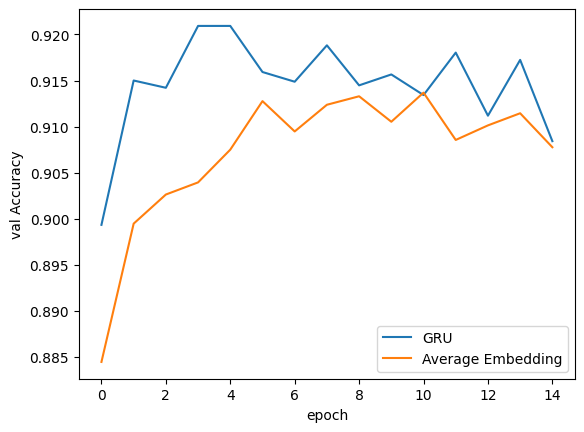

In [25]:
sns.lineplot(x="epoch", y="val Accuracy", data=gru_results, label="GRU")
sns.lineplot(x="epoch", y="val Accuracy", data=simple_emb_average_results, label="Average Embedding")

<Axes: xlabel='total time', ylabel='val Accuracy'>

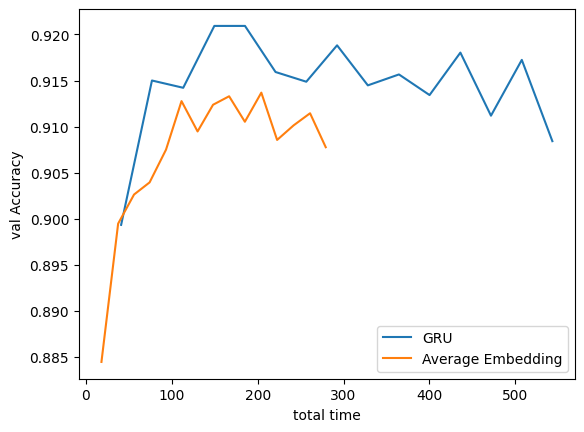

In [26]:
# it clear that training the average embeddings is around three times faster than the GRU model
sns.lineplot(x="total time", y="val Accuracy", data=gru_results, label="GRU")
sns.lineplot(x="total time", y="val Accuracy", data=simple_emb_average_results, label="Average Embedding")

##Attention Embedding

In [27]:
class AttentionEmbedding(nn.Module):

  def __init__(self, vocab_size, D, embedding_layers=3, padding_idx=None):
    super(AttentionEmbedding, self).__init__()

    self.padding_idx = padding_idx 
    self.embedding_layer = nn.Embedding(vocab_size, D, padding_idx=padding_idx)

    if isinstance(embedding_layers, int):
      self.embedding_layers = nn.Sequential(
          # (B, T, D) -> (B, T, D) 
        *[nn.Sequential(nn.Linear(embed_dim, embed_dim), nn.LeakyReLU()) for _ in range(embedding_layers)]
      )
    else:
      self.embedding_layers = embedding_layers

    self.attention = AttentionAvg(AdditiveAttentionScore(D))

  def forward(self, input):
    """
    input: (B, T) shape, dtype=int64
    output: (B, D) shape, dtype=float32
    """
    if self.padding_idx is not None:
      mask = input != self.padding_idx 
    else:
      mask = input == input # All entries are `True`

    # mask is shape (B, T)
    x = self.embedding_layer(input) # (B, T, D)
    x = self.embedding_layers(x)     # (B, T, D)

    # average over time
    context = x.sum(dim=1) / (mask.sum(dim=1).unsqueeze(1) + 1e-5)  # (B, T, D) -> (B, D)

    # If we wanted to just do normal averaging, we could return the context variable right now!
    return self.attention(x, context, mask=mask)  # ((B, T, D), (B, D)) -> (B, D)

In [28]:
# Now we can define a simple model!
attention_embedding = nn.Sequential(
  AttentionEmbedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx),  # (B, T) -> (B, D) 
  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),
  nn.BatchNorm1d(embed_dim),
  nn.Linear(embed_dim, NUM_CLASS)
)

In [ ]:
attention_embedding_results = train_network(attention_embedding, 
                            loss_func, 
                            train_loader, 
                            val_loader=test_loader, 
                            score_funcs={'Accuracy': accuracy_score}, 
                            device=device, epochs=epochs)

<Axes: xlabel='total time', ylabel='val Accuracy'>

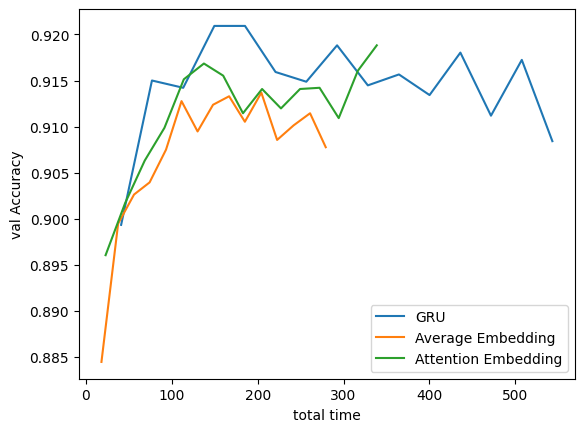

In [30]:
sns.lineplot(x="total time", y="val Accuracy", data=gru_results, label="GRU")
sns.lineplot(x="total time", y="val Accuracy", data=simple_emb_average_results, label="Average Embedding")
sns.lineplot(x="total time", y="val Accuracy", data=attention_embedding_results, label="Attention Embedding")

##Positional embeddings

Let’s use $h_i \in R^D$ to represent the embedding after feeding
in token $x_i$. Then we have a sequence of embeddings $h_1, h_2, ..., h_t, h_T$. 

We want a position vector $P(t)$, which we can add to our embeddings to create an improved embedding $\tilde h_t$ that contains information about the original content $h_t$ and its location
as the tth item in the input.

$$\tilde h_t = h_t + P(t)$$

Then we can proceed with $\tilde h_1, \tilde h_2, ..., \tilde h_t, \tilde h_T$ as the inputs to the rest of our network,
knowing that the sequential nature has been placed inside the embeddings!

It turns out we can do this with a surprisingly simple approach. We define a function for $P(t)$
using the sin and cos functions, and we use the input to the sin and cos functions to
represent the position of a vector $t$.

<Axes: >

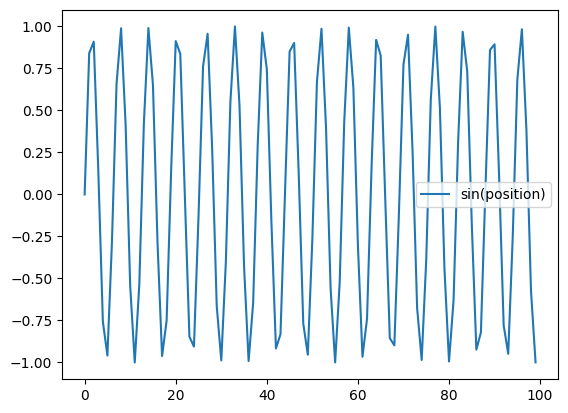

In [35]:
position = np.arange(0, 100)
sns.lineplot(x=position, y=np.sin(position), label="sin(position)")

We can improve the situation by adding a second sin call, but with a frequency
component `f`.

<Axes: >

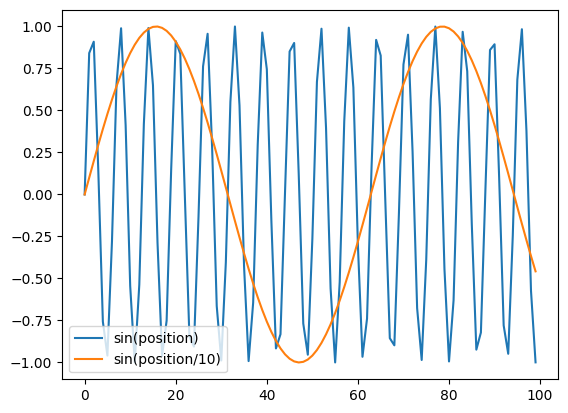

In [36]:
position = np.arange(0, 100)
sns.lineplot(x=position, y=np.sin(position), label="sin(position)")
sns.lineplot(x=position, y=np.sin(position/10), label="sin(position/10)")

This shows that if we keep adding frequencies `f` to the calculation, we can begin
to infer from the combination of values our exact location within the input sequence.

We define a position encoding function $P(t)$ that returns a `D` dimensional vector by
creating sin and cos values at different frequencies $f_1, f_2,..., f_{D/2}$. We only need $D/2$
frequencies because we use both a sin and cos value for each frequency. That gives us as the representation for our encoding vectors.

$$
P(t) = \begin{bmatrix} 
sin(\frac {t}{f_1}) \\
cos(\frac {t}{f_1}) \\
sin(\frac {t}{f_2}) \\
cos(\frac {t}{f_2}) \\
... \\
sin(\frac {t}{f_{\frac {D}{2}}}) \\
cos(\frac {t}{f_{\frac {D}{2}}})
\end{bmatrix} 
$$

But how do we define $f_k$?

The paper
that originally proposed this recommended using the following:

$$ f_k = 10000^{\frac {2.k}{D}} $$

Let’s see a quick example of what this looks like.

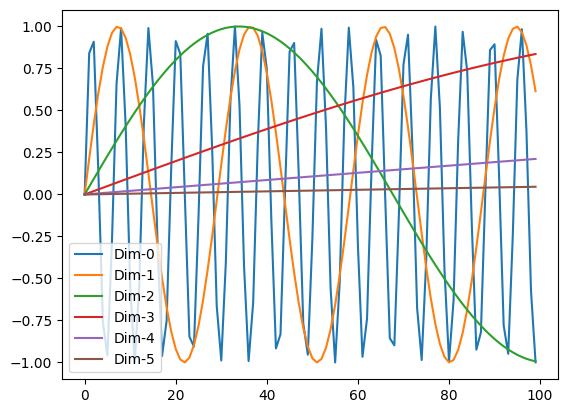

In [37]:
# For simplicity, we useD = 6 dimensions
dimensions = 6
position = np.expand_dims(np.arange(0, 100), 1)

# computes the frequency f in a numerically stable way
div = np.exp(np.arange(0, dimensions * 2, 2) * (-math.log(10000.0) / (dimensions * 2)))
for i in range(dimensions):
  sns.lineplot(x=position[:, 0], y=np.sin(position * div)[:, i], label=f"Dim-{str(i)}")

As we start adding more dimensions with more frequencies, it becomes easier to identify
unique positions in time.

This is what our network will use to extract information about
the location from the data.

This specific form of a positional encoding also has some nice mathematical properties
that make it easier for neural networks to learn.

Now let’s define a new PyTorch Module
that applies this positional encoding for us.

In [38]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout=0.1, max_len=5000, batch_first=False):
    super(PositionalEncoding, self).__init__()

    self.dropout = nn.Dropout(p=dropout)
    self.d_model = d_model

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    # Done so that when we call .to(device), this array will move to it
    self.register_buffer("pe", pe)
    self.batch_first = batch_first

  def forward(self, x):
    if self.batch_first:
      # this code works on (T, B, D) data, so we need to reorder if the input is (B, T, D).
      x = x.permute(1, 0, 2)
    # mixes the input and positional information
    x = x * np.sqrt(self.d_model) + self.pe[: x.size(0), :]
    # Regularizes to avoid overfitting
    x = self.dropout(x)

    # now go back to (B, T, D) shape
    if self.batch_first:
      x = x.permute(1, 0, 2)

    return x

With our new positional encoding, we can redefine the simple averaging approach from
before by inserting our `PositionalEncoding` class directly after the `nn.Embedding` layer.

It does not impact the tensor’s shape in any way, so everything else can remain the same.

In [39]:
simple_positional_embedding = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx),  # (B, T) -> (B, T, D) 
  PositionalEncoding(embed_dim, batch_first=True),                     

  # now we will pretend that D is the number of channels in this new interpreation of the data!
  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),

  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),

  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),

  # let's reduce to a fixed length!
  nn.AdaptiveAvgPool2d((1, None)), # (B, T, D) -> (B, 1, D)

  nn.Flatten(),            # (B, 1, D) -> (B, D)

  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),
  nn.BatchNorm1d(embed_dim),
  nn.Linear(embed_dim, NUM_CLASS)
)

In [ ]:
simple_positional_embedding_results = train_network(simple_positional_embedding, 
                            loss_func, 
                            train_loader, 
                            val_loader=test_loader, 
                            score_funcs={'Accuracy': accuracy_score}, 
                            device=device, epochs=epochs)

Let's define the
positional encoding followed by three rounds of hidden layers.

In [40]:
embedding_layers = nn.Sequential(
  *(
      [PositionalEncoding(embed_dim, batch_first=True)] + 
      [nn.Sequential(nn.Linear(embed_dim, embed_dim), nn.LeakyReLU()) for _ in range(3)]
  )
)

Now, we can define an attention-based network with positional encoding.

In [42]:
attention_positional_embedding = nn.Sequential(
  AttentionEmbedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx, embedding_layers=embedding_layers), # (B, T) -> (B, D)
  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),
  nn.BatchNorm1d(embed_dim),
  nn.Linear(embed_dim, NUM_CLASS)
)

In [ ]:
attention_positional_embedding_results = train_network(attention_positional_embedding, 
                            loss_func, 
                            train_loader, 
                            val_loader=test_loader, 
                            score_funcs={'Accuracy': accuracy_score}, 
                            device=device, epochs=epochs)

<Axes: xlabel='total time', ylabel='val Accuracy'>

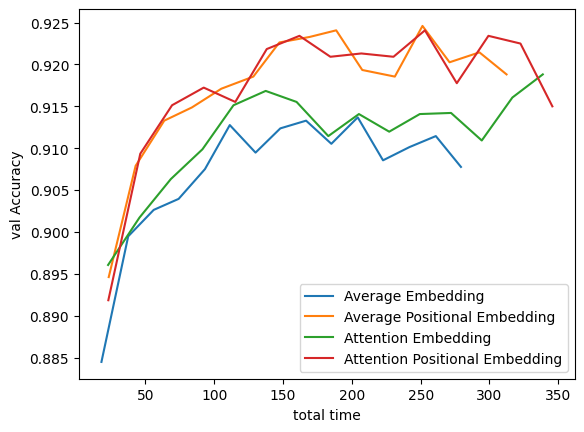

In [44]:
sns.lineplot(x="total time", y="val Accuracy", data=simple_emb_average_results, label="Average Embedding")
sns.lineplot(x="total time", y="val Accuracy", data=simple_positional_embedding_results, label="Average Positional Embedding")
sns.lineplot(x="total time", y="val Accuracy", data=attention_embedding_results, label="Attention Embedding")
sns.lineplot(x="total time", y="val Accuracy", data=attention_positional_embedding_results, label="Attention Positional Embedding")

Our positional embeddings provide a significant benefit, accuracy
is improved across the board, and there are less-severe dips in accuracy that indicate
less overfitting.

These results provide evidence that our hypothesis about sequence order helping
prevent overfitting was also correct, particular with the attention-based approach. Both
versions using the positional encodings still fluctuate but do not drop in accuracy as
quickly with more epochs of training. This shows how we can use a completely different
kind of approach to encode sequence information into our models.

Our attention-based embedding is definitely a better idea: let’s compare just that to
the earlier GRU results. With this combination, we begin to match or even outperform
the GRU-based RNN in terms of accuracy, and it is over twice as fast to train! A pretty
great combo.

<Axes: xlabel='total time', ylabel='val Accuracy'>

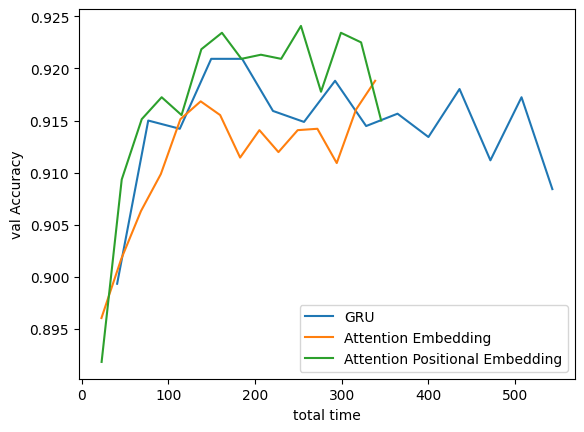

In [45]:
sns.lineplot(x="total time", y="val Accuracy", data=gru_results, label="GRU")
sns.lineplot(x="total time", y="val Accuracy", data=attention_embedding_results, label="Attention Embedding")
sns.lineplot(x="total time", y="val Accuracy", data=attention_positional_embedding_results, label="Attention Positional Embedding")

The takeaway is that positional encodings are a cheap, fast, and effective way to encode
sequence information into our networks. 

Surprisingly, positional encodings were not
invented on their own but rather in conjunction with `Transformers`.

So in most current deep learning, you won’t see a positional
encoding used outside of transformers, but I have found them widely useful beyond
transformers as a fast and easy way to endow a model with the concept of time/ordered
data.